In [16]:
from sympy import symbols,Symbol, Matrix, cos, pi, sqrt, Rational, simplify, collect, factor,Function



# Define variables
R_s,L_1s,L_sm, L_sr, L_rs,R_r = symbols('R_s L_1s L_sm L_sr L_rs R_r')
K_sa, K_sb, K_sc = symbols('K_sa K_sb K_sc')
theta_r, beta = symbols('theta_r beta')
omega_r,L_1r=symbols('omega_r L_1r')
# Equation (1): Short-circuit coefficients


# Equation (2): Stator Resistance Matrix with Short Circuit
R_s_star = Matrix([
    [K_sa * R_s, 0, 0],
    [0, K_sb * R_s, 0],
    [0, 0, K_sc * R_s]
])

# Equation (3): Stator Self-Inductance Matrix with Short Circuit
L_s_star = Matrix([
    [K_sa**2 *(L_1s+L_sm), K_sa*K_sb*L_sm, K_sa*K_sc*L_sm],
    [K_sa*K_sb*L_sm, K_sb**2 *(L_1s +L_sm), K_sb*K_sc*L_sm],
    [K_sa*K_sc*L_sm, K_sb*K_sc*L_sm, K_sc**2 *(L_1s +L_sm)]
])

# Equation (4): Mutual Inductance Matrix L_sr* (stator to rotor)
L_sr_abc = L_sr * Matrix([
    [K_sa * cos(theta_r),          K_sa * cos(theta_r + 2*pi/3),   K_sa * cos(theta_r - 2*pi/3)],
    [K_sb * cos(theta_r - 2*pi/3), K_sb * cos(theta_r),            K_sb * cos(theta_r + 2*pi/3)],
    [K_sc * cos(theta_r + 2*pi/3), K_sc * cos(theta_r - 2*pi/3),   K_sc * cos(theta_r)]
])

# Equation (5): Mutual Inductance Matrix L_rs* (rotor to stator)
L_rs_abc = L_rs * Matrix([
    [K_sa * cos(theta_r),         K_sb * cos(theta_r - 2*pi/3),   K_sc * cos(theta_r + 2*pi/3)],
    [K_sa * cos(theta_r + 2*pi/3), K_sb * cos(theta_r),           K_sc * cos(theta_r - 2*pi/3)],
    [K_sa * cos(theta_r - 2*pi/3), K_sb * cos(theta_r + 2*pi/3),  K_sc * cos(theta_r)]
])

# Clarke Transformation matrix (theta = 0)
T = Matrix([
    [1, -Rational(1,2), -Rational(1,2)],
    [0, -sqrt(3)/2, sqrt(3)/2],
    [Rational(1,2), Rational(1,2), Rational(1,2)]
])

# Inverse Clarke (for rotor at theta = beta)
T_inv_beta = Matrix([
    [1, 0, 1],
    [-Rational(1,2), -sqrt(3)/2, 1],
    [-Rational(1,2), sqrt(3)/2, 1]
])

# Equation (6): dq0 Transformed Resistance Matrix
R_s_dq0 = simplify(Rational(2,3) * T * R_s_star * T_inv_beta)

# Equation (7): dq0 Transformed Stator Inductance Matrix
L_s_dq0 = simplify(Rational(2,3) * T * L_s_star * T_inv_beta)

# Equation (8): dq0 Transformed Stator-Rotor Mutual Inductance Matrix
L_sr_dq0 = simplify(Rational(2,3) * T * L_sr_abc * T_inv_beta).subs([(theta_r, 0)])
# Equation (9): dq0 Transformed Rotor-Stator Mutual Inductance Matrix
L_rs_dq0 = simplify(Rational(2,3) * T * L_rs_abc * T_inv_beta).subs([(theta_r, 0)])

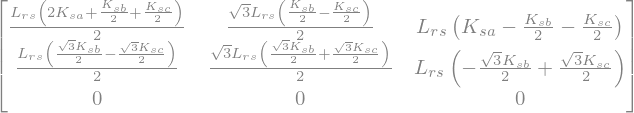

In [17]:
L_rs_dq0

In [18]:
R_s_dq0=R_s_dq0.subs([(K_sa,Rational(20,20)),(K_sb,1),(K_sc,1),(R_s,0.435)])
L_s_dq0=L_s_dq0.subs([(K_sa,Rational(20,20)),(K_sb,1),(K_sc,1),(L_1s,0.0024),(L_sm,0.0695)])
L_sr_dq0=L_sr_dq0.subs([(K_sa,Rational(20,20)),(K_sb,1),(K_sc,1),(L_sr,0.00228)])
L_rs_dq0=L_rs_dq0.subs([(K_sa,Rational(20,20)),(K_sb,1),(K_sc,1),(L_rs,0.00168)])

In [19]:
from sympy import init_printing
from sympy.abc import t
init_printing()
#Equation (10):flux matrix
# Time-varying functions
i_sq, i_sd, i_s0 = symbols('i_{s_q} i_{s_d} i_{s_0}', cls=Function)
i_rq, i_rd, i_r0 = symbols('i_{r_q} i_{r_d} i_{r_0}', cls=Function)
lambda_sq, lambda_sd, lambda_s0 = symbols('\\lambda_{s_q} \\lambda_{s_d} \\lambda_{s_0}', cls=Function)
lambda_rq, lambda_rd, lambda_r0 = symbols('\\lambda_{r_q} \\lambda_{r_d} \\lambda_{r_0}', cls=Function)
v_sq, v_sd, v_s0 = symbols('v_{s_q} v_{s_d} v_{s_0}',cls=Function)
v_rq, v_rd, v_r0 = symbols('v_{r_q} v_{r_d} v_{r_0}',cls=Function)

#i vec
i_vec = Matrix([
    i_sq(t),
    i_sd(t),
    i_s0(t),
    i_rq(t),
    i_rd(t),
    i_r0(t)
])
#diagonal matrix rotor self inductance
# Rotor self-inductance matrix
L_r_diag = Matrix([
    [L_1r + L_sm, 0, 0],
    [0, L_1r + L_sm, 0],
    [0, 0, L_1r]
])
L_total=Matrix.vstack(Matrix.hstack(L_s_dq0, L_sr_dq0),
                      Matrix.hstack(L_rs_dq0, L_r_diag))
lambda_vec=L_total * i_vec
lambda_sq, lambda_sd, lambda_s0, lambda_rq, lambda_rd, lambda_r0 =lambda_vec
#eqn 11 voltage stator
i_s_vec=Matrix([i_sq(t),i_sd(t),i_s0(t)])
lamda_s_vec=Matrix([lambda_sq,lambda_sd,lambda_s0])
v_s_vec=R_s_dq0 * i_s_vec + lamda_s_vec.diff(t)
#eqn 12 voltage rotor
i_r_vec=Matrix([i_rq(t),i_rd(t),i_r0(t)])
lambda_r_vec=Matrix([lambda_rq,lambda_rd,lambda_r0])
J = Matrix([
    [0, -omega_r, 0],
    [omega_r, 0, 0],
    [0, 0, 0]])
R_r_vec=Matrix([[R_r,0,0],
                 [0,R_r,0],[0,0,R_r]])
v_r_vec = R_r_vec * i_r_vec + lambda_r_vec.diff(t) + J * lambda_r_vec
#eqn 13 total
v_total = Matrix.vstack(v_s_vec, v_r_vec)

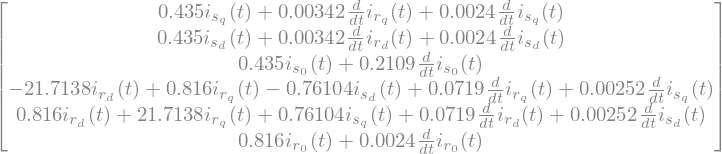

In [20]:
v_total=v_total.subs([(R_r,0.816),(L_1r,0.0024),(L_sm,0.0695),(omega_r,302)])
v_total

In [21]:
from sympy import dsolve,Eq
x1,x2,x3,x4,x5,x6=v_total
system=[Eq(282.84,x1),Eq(0,x2),Eq(0,x3),Eq(232.84,x4),Eq(0,x5),Eq(0,x6)]
s1,s2,s3,s4,s5,s6=dsolve(system,[x for x in i_vec],ics={i_sq(0):0,i_sd(0):0,i_s0(0):0,i_rq(0):0,i_rd(0):0,i_r0(0):0})

In [22]:
s1,s2,s3,s4,s5,s6

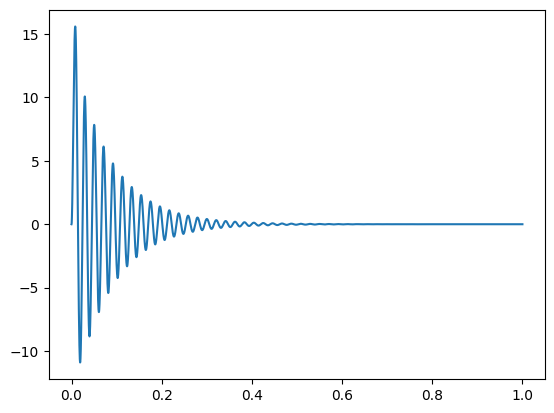

In [32]:

import sympy,numpy
import matplotlib.pyplot as plt
n1=sympy.lambdify(t,s2.rhs,"numpy")
x_vals=numpy.linspace(0,1,40000)
y_vals=n1(x_vals)
plt.plot(x_vals,y_vals)